# n-widths for transport problems 
## Heaviside step function
$u(x;\mu) = f(x, \mu) = \begin{cases}
    0.0 & \text{if $x < \mu $} \\
    0.5 & \text{if $x = \mu $} \\
    1.0 & \text{if $x > \mu $}
  \end{cases}$ 
  
  $ x \in ({0,1})$ and $ \mu \in ({0,1})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
from initial_conditions import Domain, Heaviside, Ramp, SmoothJump, Sigmoid
from basis_functions import SVD, Trigonometric, Greedy, LNA, LPF

We need to set some boring plotting options...:

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')

8.030570172000001


In [4]:
def plot_modes(x, X, r=10):
    for i in range(r):
        plt.plot(x, X[:, i], "o", ms=1, color=cmap(i/r))
    plt.xlim([0, 1])
    plt.grid(which="both")
    return


def plot_singular_values(S):
    S = S/S[0]  # normalize singular values to make for a better comparison!
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(S)+1), S, "k.", ms=1)
    ax1.set_xlabel("order")
    ax1.set_ylabel("singular value")
    ax1.set_yscale('log')
    ax1.set_xlim([0, len(S)])
    ax1.set_ylim([1e-6, 100])
    ax1.grid(which="both")
    plt.tight_layout()
    return None


def plot_error(rms_error, max_error):
    fig, ax = plt.subplots()
    ax.plot(max_error, ".", label="max_error")
    ax.plot(rms_error, ".", label="rms_error")
    ax.set_yscale('log')
    plt.legend()
    return ax

In [5]:
m, n, r = 2000, 500, 500
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

{'label': 'heaviside'}
0.50025
generating greedy basis. rank: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 20

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


498, 499, 


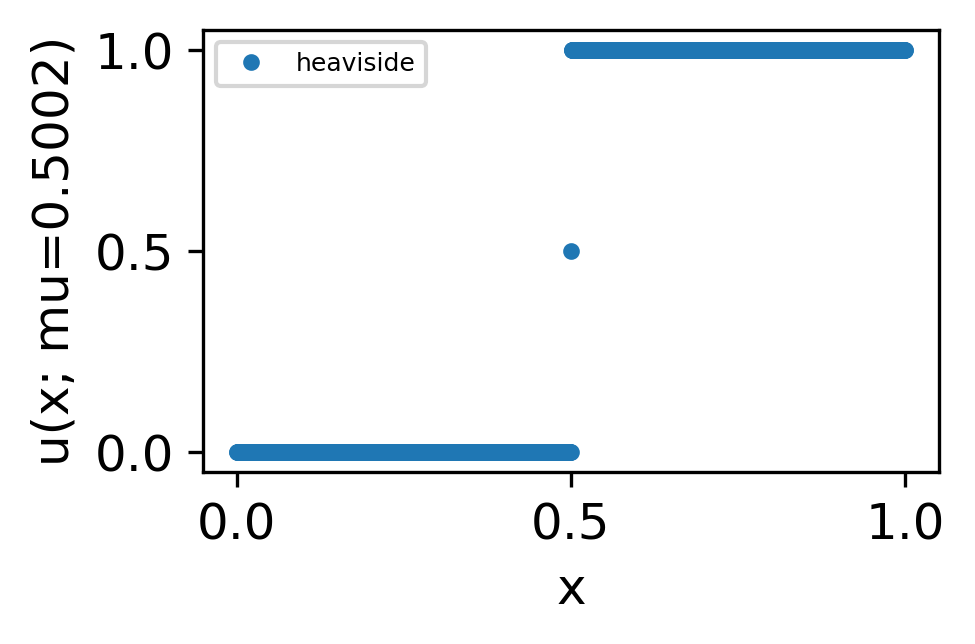

In [6]:
u_hs = Heaviside()
u_hs.plot(x(), label=u_hs.name)
plt.legend(prop={'size': 6})
X = u_hs(x(), mu())

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u_hs, x)
lpf_basis = LPF(x)

In this case, the left singular values can be described analytically with orthogonal sine functions, where the phase length $ \omega = \frac{2  \pi }{4 T}(2 i+1) $ and the amplitude $A = 2 \sqrt{\Delta x} sin(\frac{\pi}{4})$. Note the similarity to the fourier series, where ...

$\varphi_i = A sin(\omega x)$

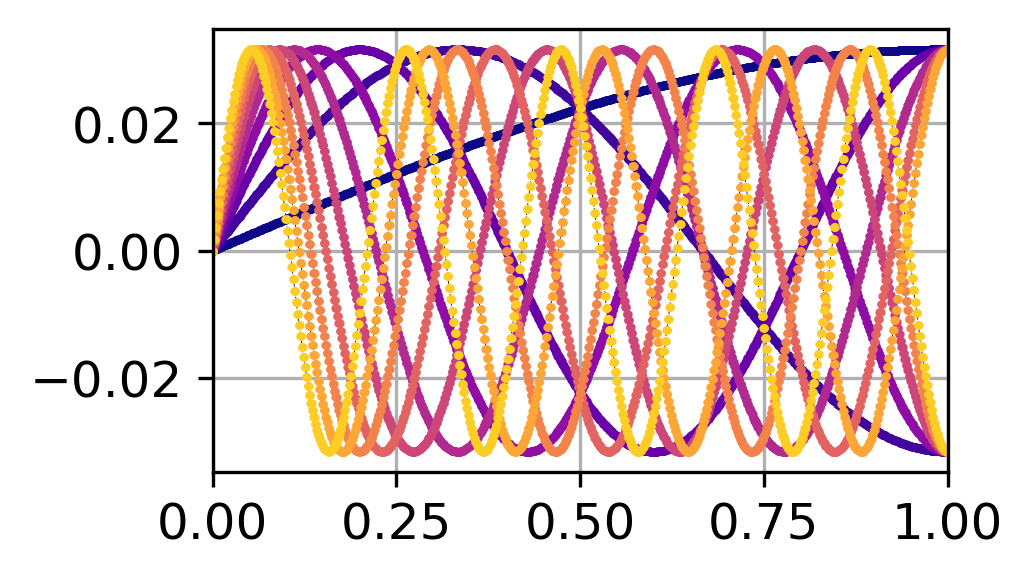

In [7]:
U = svd_basis.U
U_trig = trig_basis.U

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(x(), U_trig[:, i], "k--", lw=.2)
plot_modes(x(), U, r=10)
plt.show()

The right singular values can be described analytically too with orthogonal cosine functions, with the same phase lengths and the amplitude $A = 2 \sqrt{\Delta \mu} sin(\frac{\pi}{4})$.

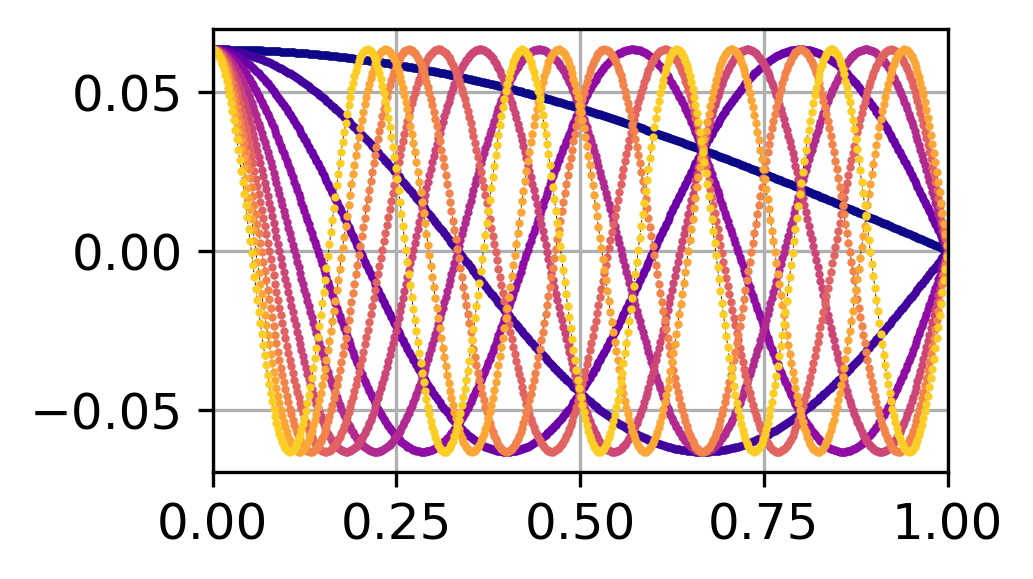

In [8]:
VT = svd_basis.VT
V_trig = Trigonometric(mu, fun=np.cos).U

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(mu(), V_trig[:, i], "k--", lw=.2)
plot_modes(mu(), VT.T, r=10)
plt.show()

singular values decay with 1/n

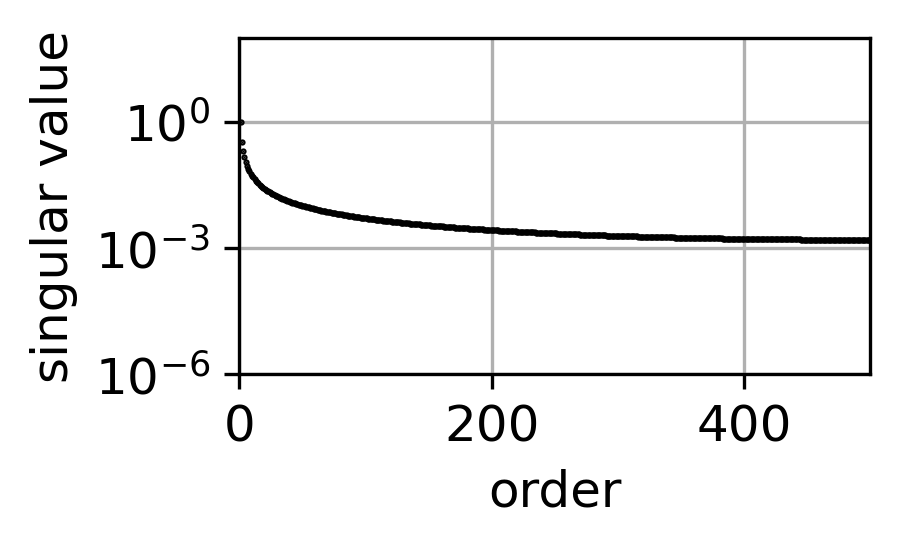

In [9]:
S = svd_basis.S
plot_singular_values(S)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


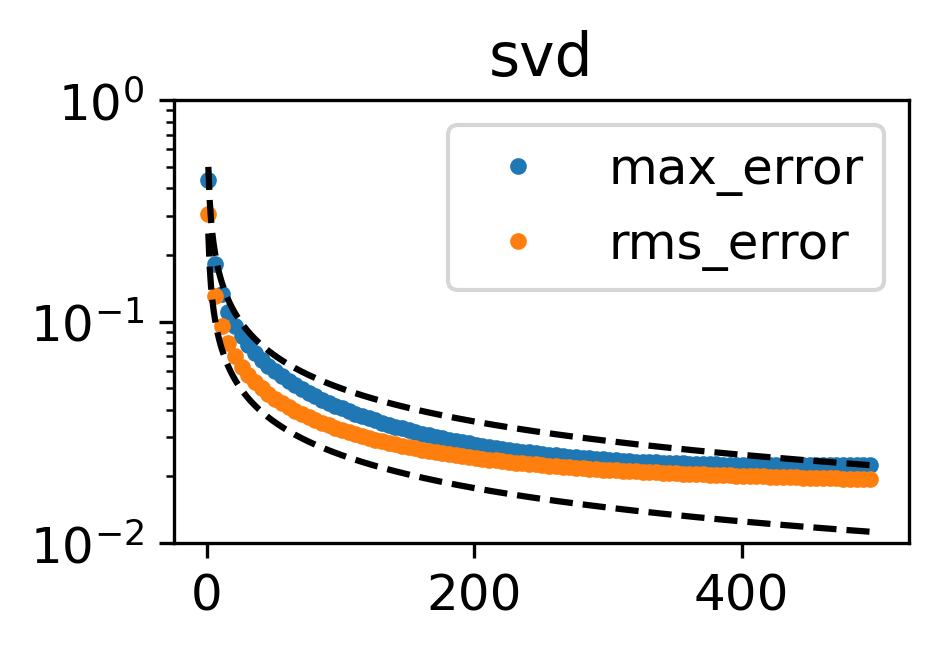

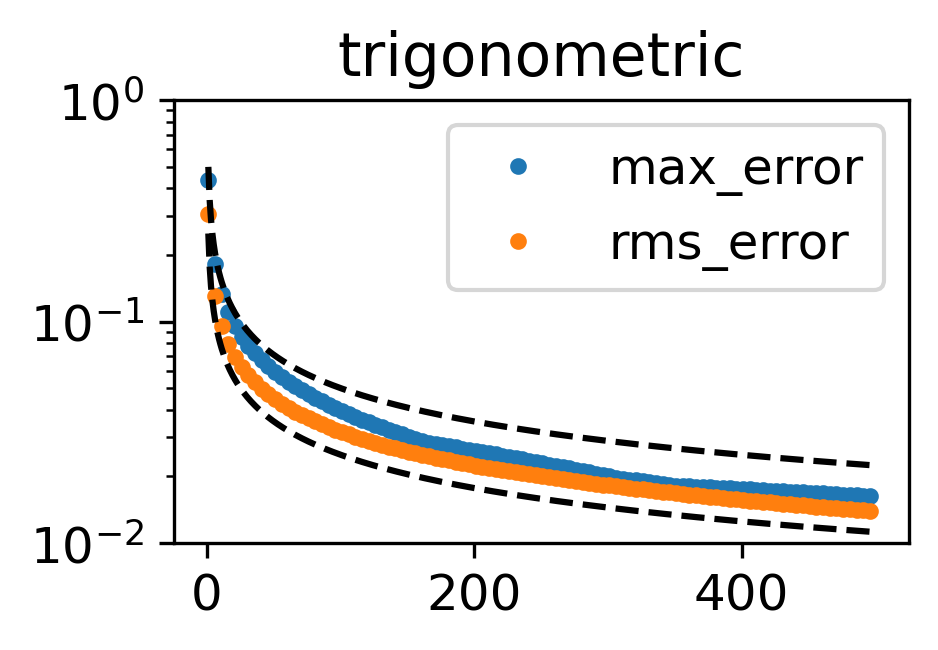

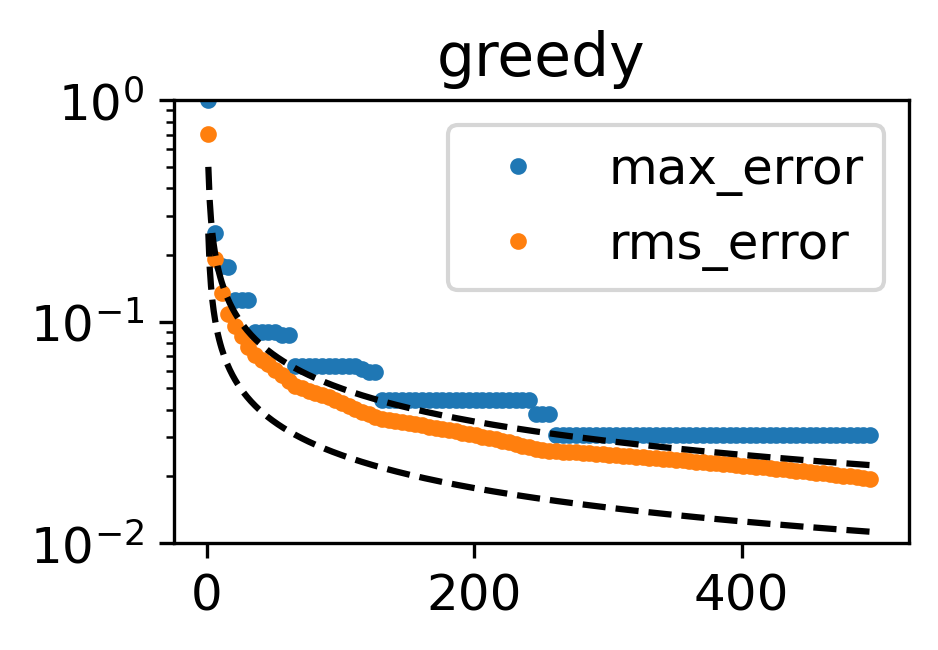

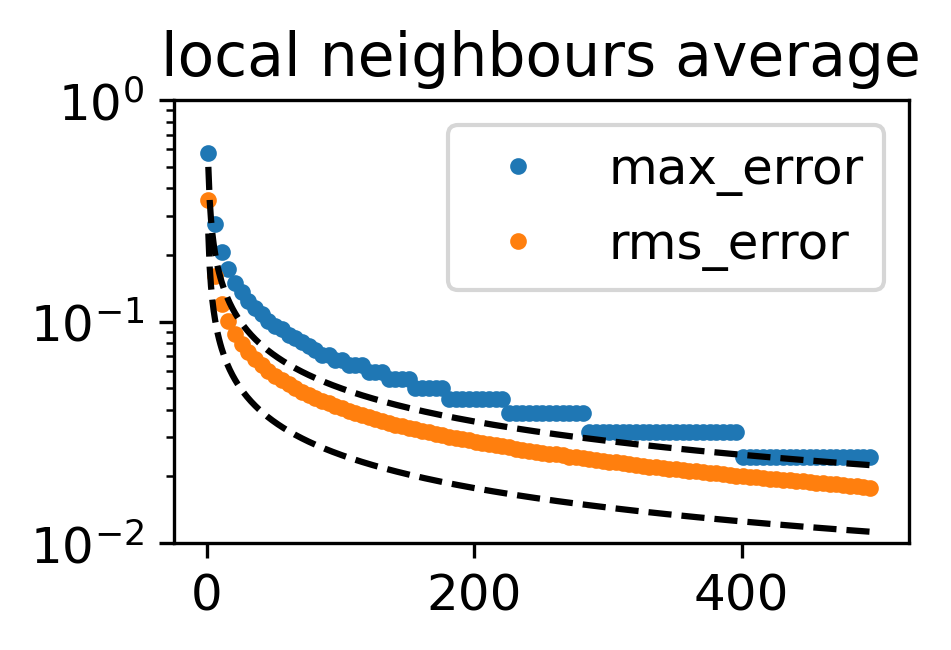

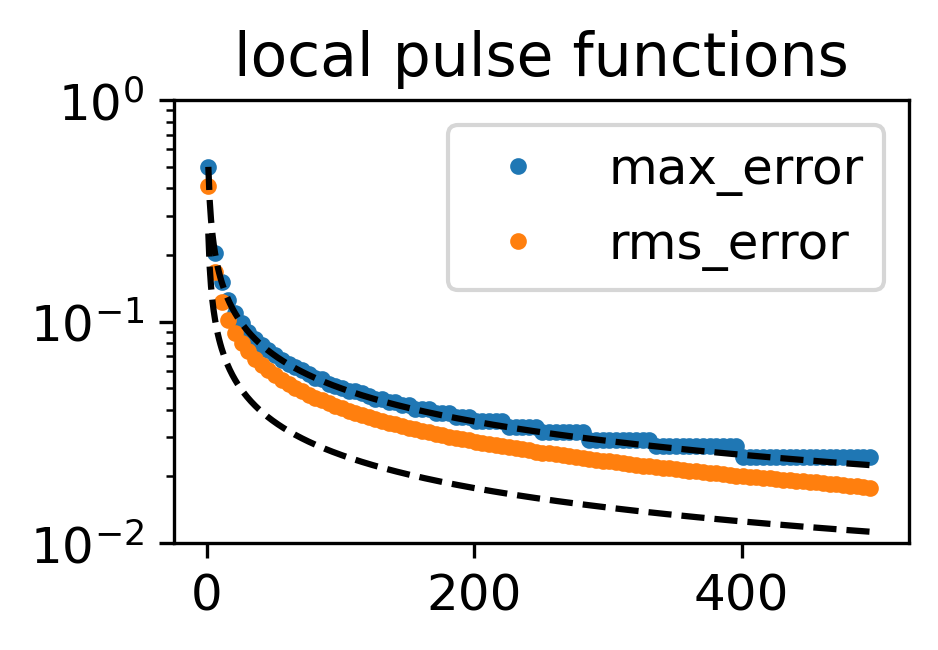

In [10]:
mu_test = Domain([0, 1], 1000)
X_test = u_hs(x(), mu_test())
rms_error_hs, max_error_hs = [], []

for i, basis in enumerate([svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]):
    rmse, maxe = basis.calc_error(X_test, r)
    rms_error_hs.append(rmse)
    max_error_hs.append(maxe)
    ax = plot_error(rmse, maxe)
    nn = np.arange(1, r+1)
    ax.plot(nn, 1/(2*nn**.5), "k--", label="1/(2sqrt(n)")
    ax.plot(nn, 1/(4*nn**.5), "k--", label="1/(4sqrt(n)")
    ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

max error for this basis can bee computed. Not the Kol n-width, since there might exist a better basis that minimizes the max error.
We can test different sets of basis vectors.
The greedy basis is known to approximate the n-width in some cases, see [ref]

## Ramp function
is continuous, but not differentiable at $x = t +- epsilon$, so it is of class $C^0$

In [11]:
epsilon1 = 0.025

{}
0.50025
generating greedy basis. rank: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

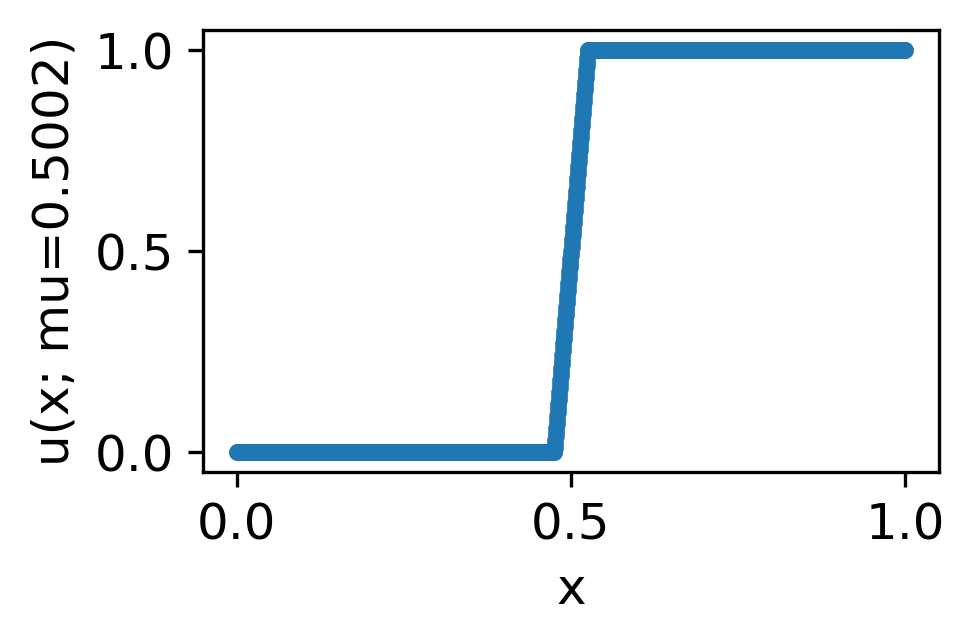

In [12]:
u_rp = Ramp(epsilon1)
u_rp.plot(x())
X = u_rp(x(), mu())

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u_rp, x)
lpf_basis = LPF(x)

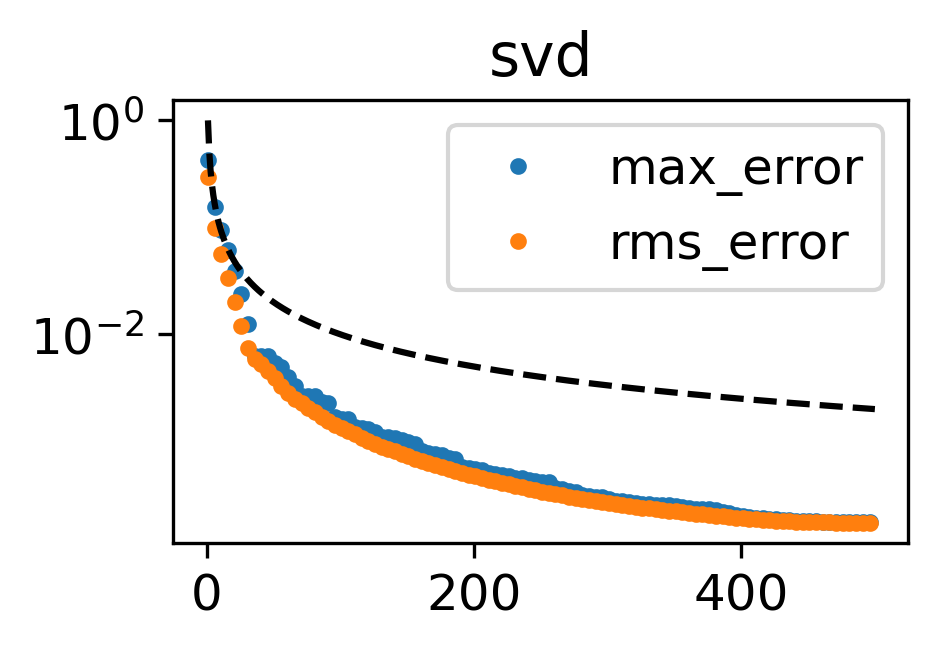

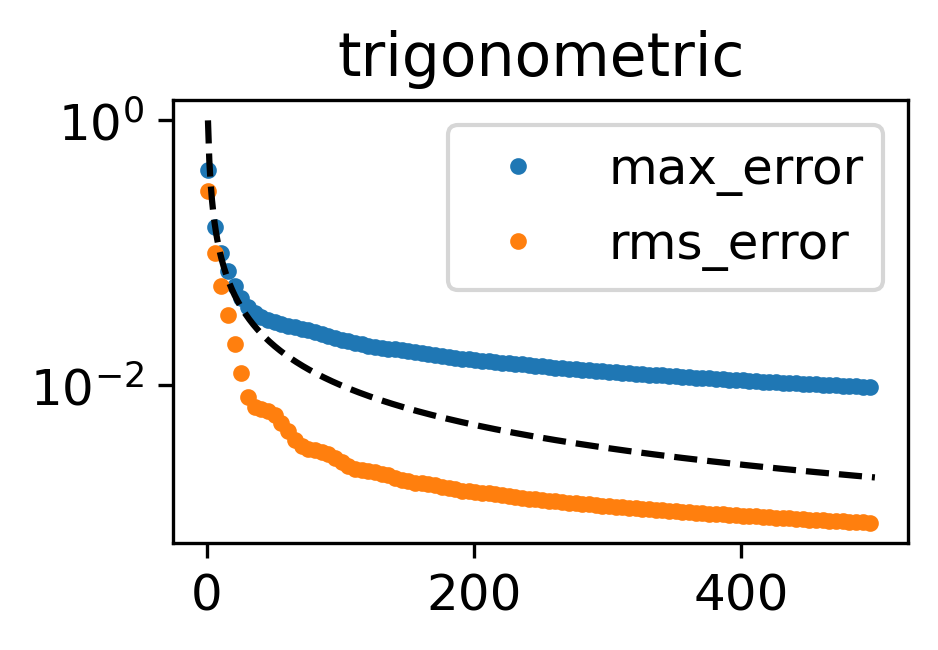

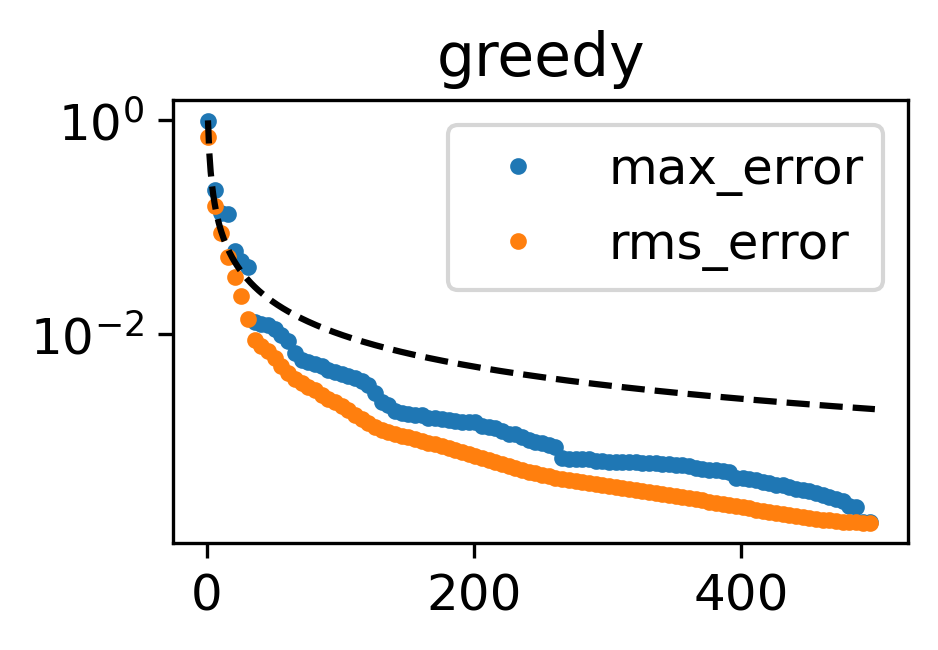

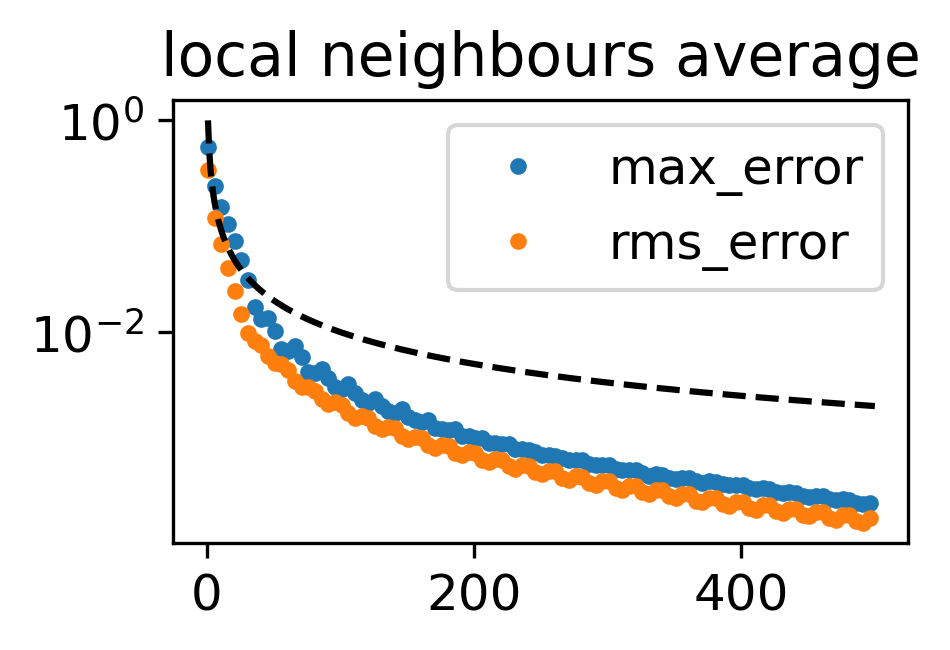

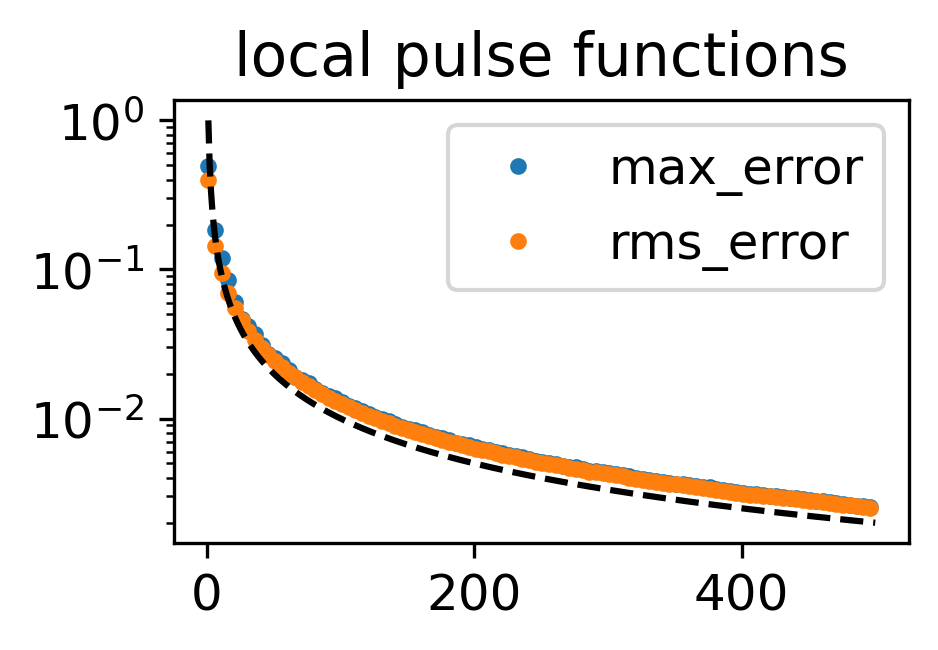

In [13]:
X_test = u_rp(x(), mu_test())
rms_error_rp, max_error_rp = [], []

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:
    rmse, maxe = basis.calc_error(X_test, r)
    rms_error_rp.append(rmse)
    max_error_rp.append(maxe)
    ax = plot_error(rmse, maxe)
    nn = np.arange(1, r+1)
    ax.plot(nn, 1/nn, "k--", label="1/n")
    #ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

## Smooth jump with the first derivative being continuous
is continuous and once differentiable, so it is of class $C^1$

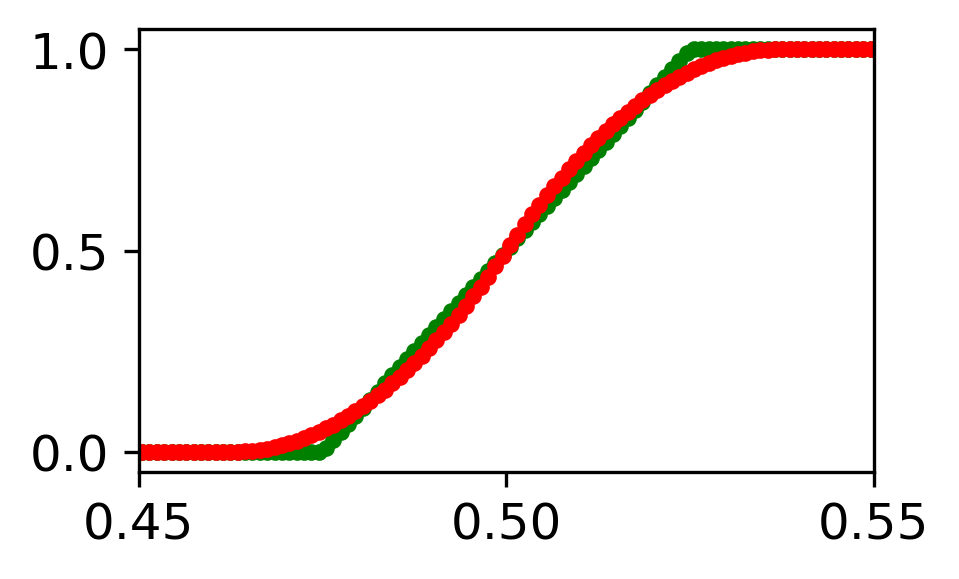

0.03719494731015149


In [14]:
def f(tt, eps):
    u_sj = SmoothJump(eps)
    res = u_sj(tt, mu=.5)
    return res
    

def fit_sj(eps):
    tt = np.linspace(0, 1, 1000)
    yy = u_rp(tt, mu=.5)
    popt, pcov = curve_fit(f, tt, yy)
    eps_opt = popt[0]
    
    fig, ax = plt.subplots()
    plt.plot(tt, yy, "g.")
    plt.plot(tt, f(tt, eps_opt), "r.")
    plt.xlim([.45, .55])
    plt.show()
    return eps_opt

epsilon2 = fit_sj(epsilon1)
print(epsilon2)

{}
0.50025
generating greedy basis. rank: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

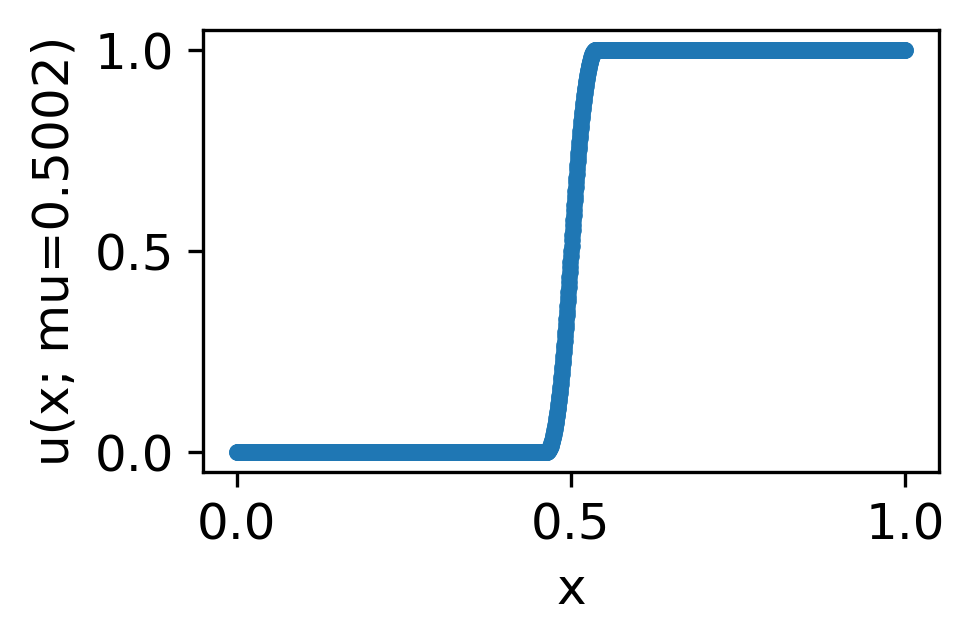

In [15]:
u_sj = SmoothJump(epsilon2)
u_sj.plot(x())
X = u_sj(x(), mu())

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u_sj, x)
lpf_basis = LPF(x)

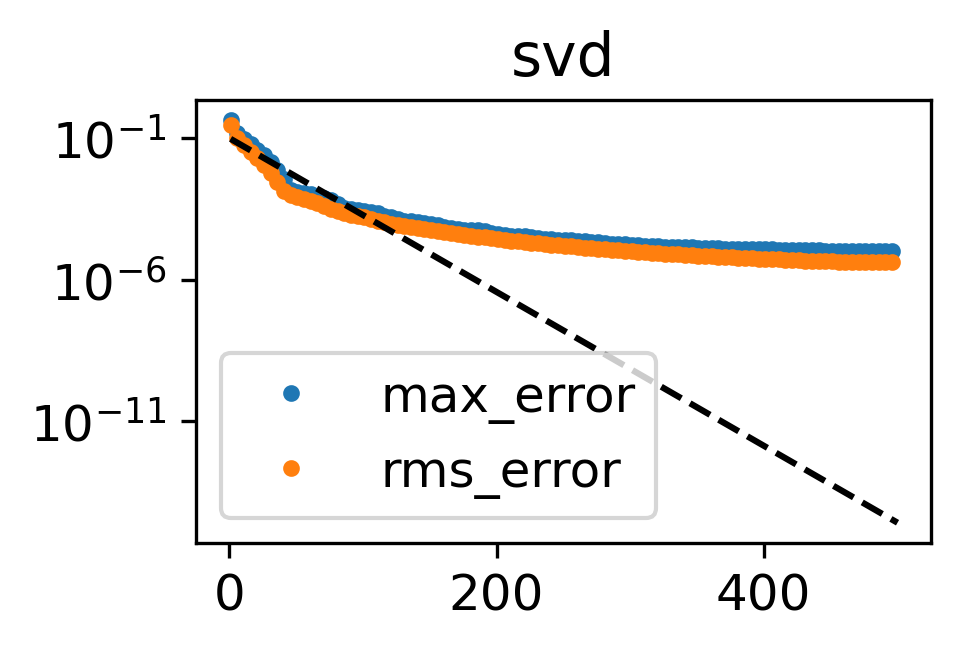

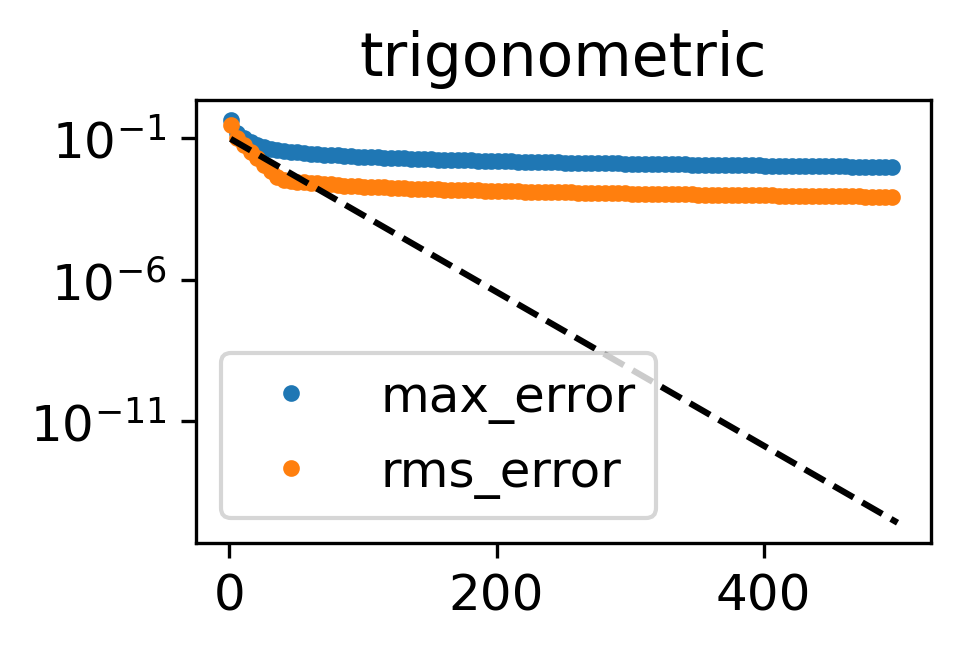

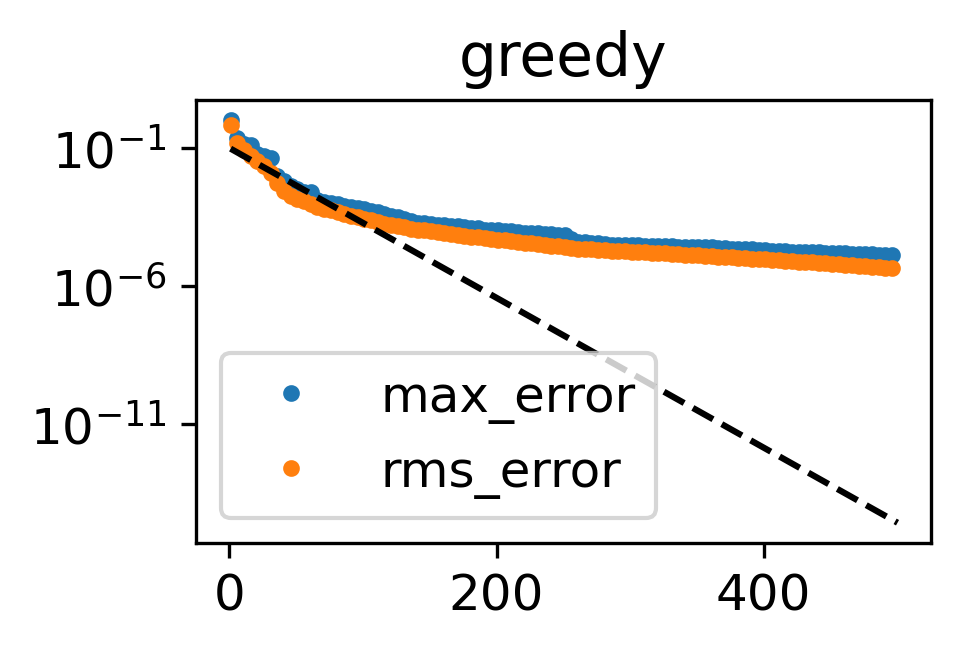

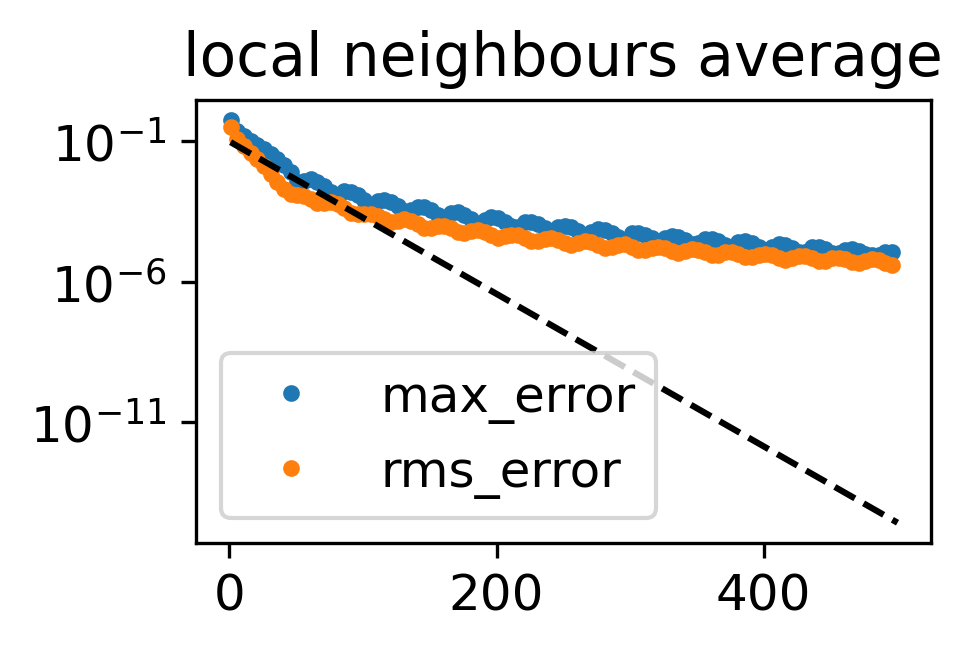

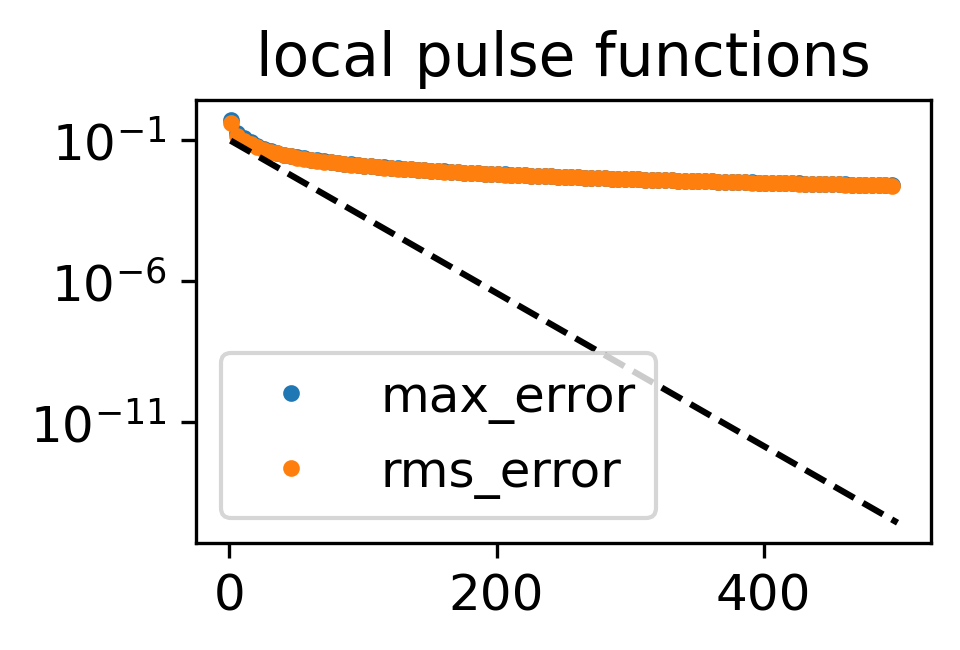

In [16]:
X_test = u_sj(x(), mu_test())
rms_error_sj, max_error_sj = [], []

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:
    rmse, maxe = basis.calc_error(X_test, r)
    rms_error_sj.append(rmse)
    max_error_sj.append(maxe)
    ax = plot_error(rmse, maxe)
    nn = np.arange(1, r+1)
    ax.plot(nn, .1/np.exp(nn/16), "k--", label=".1/exp(n/16)")
    #ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

## Sigmoid function
is continuous and infinitively differentiable, so it is of class $C^\inf$

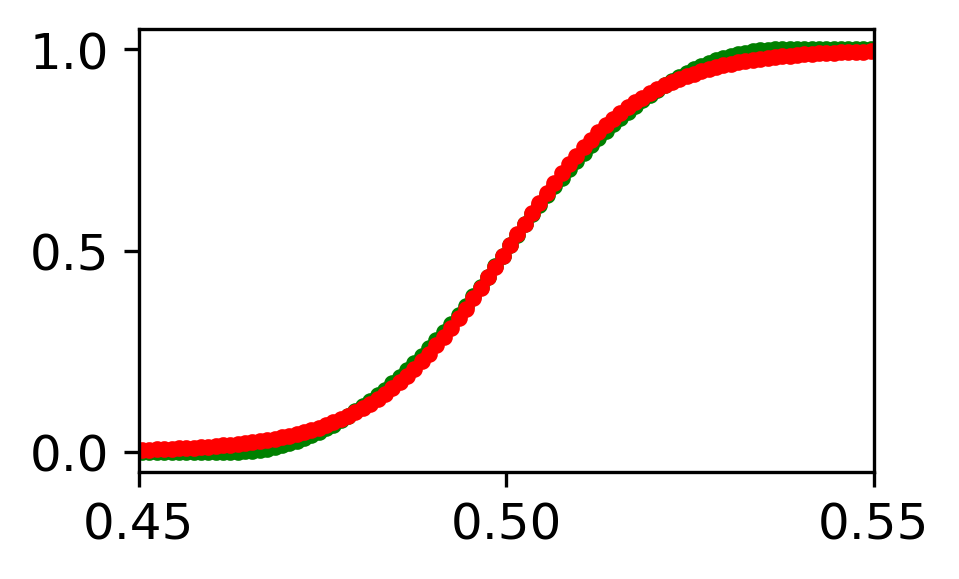

In [17]:
def f(tt, a):
    u_ = Sigmoid(a)
    res = u_(tt, mu=.5)
    return res

def fit_sigmoid(eps):
    tt = np.linspace(0, 1, 1000)
    yy = u_sj(tt, mu=.5)
    popt, pcov = curve_fit(f, tt, yy, [50])
    a = popt[0]
    
    fig, ax = plt.subplots()
    plt.plot(tt, yy, "g.")
    plt.plot(tt, f(tt, a), "r.")
    plt.xlim([.45, .55])
    plt.show()
    return a

a = fit_sigmoid(epsilon2)

{}
0.50025
generating greedy basis. rank: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

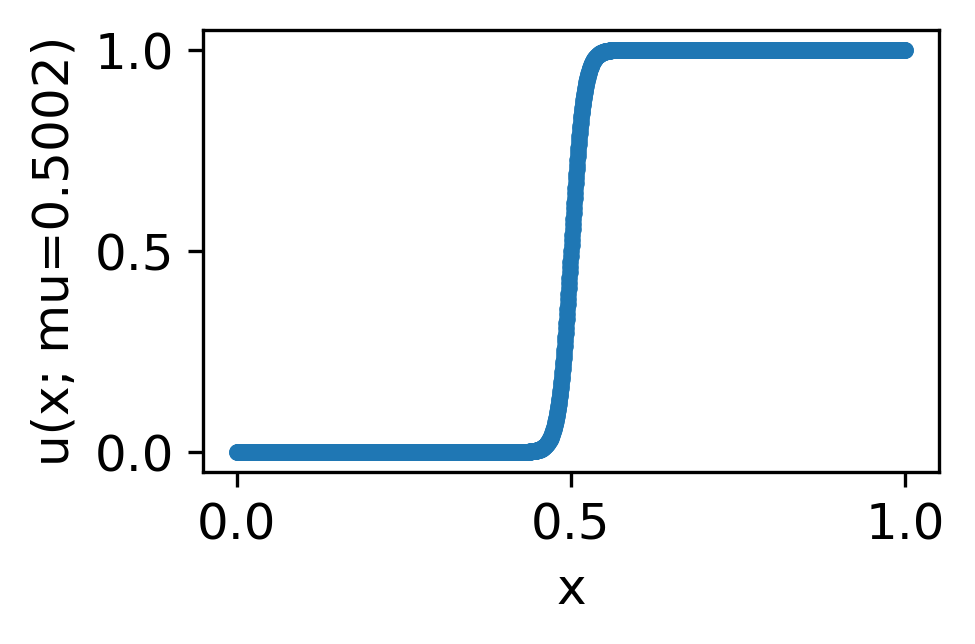

In [18]:
u_sg = Sigmoid(a)
u_sg.plot(x())
X = u_sg(x(), mu())

svd_basis = SVD(X)
trig_basis = Trigonometric(x)
greedy_basis = Greedy(X, r=r)
lna_basis = LNA(u_sg, x)
lpf_basis = LPF(x)

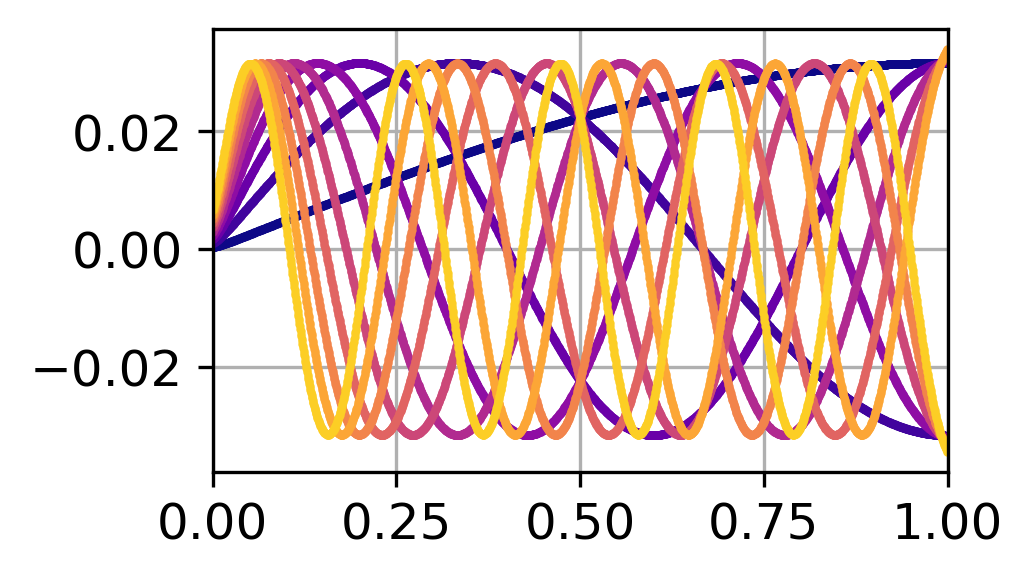

In [19]:
U = svd_basis.U
U_trig = trig_basis.U

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(x(), U_trig[:, i], "k--", lw=.2)
plot_modes(x(), U, r=10)
plt.show()

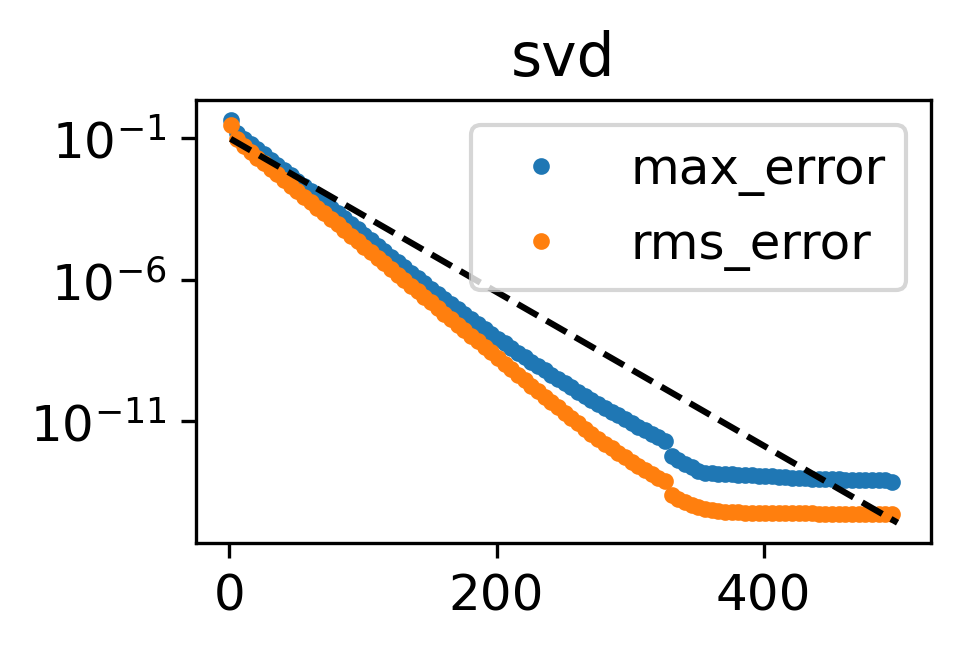

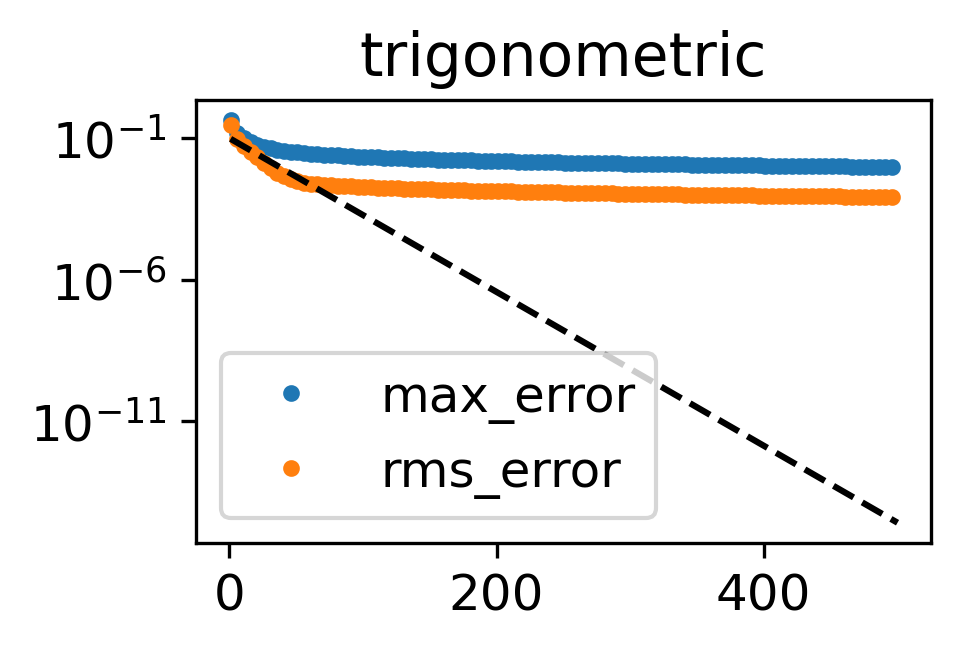

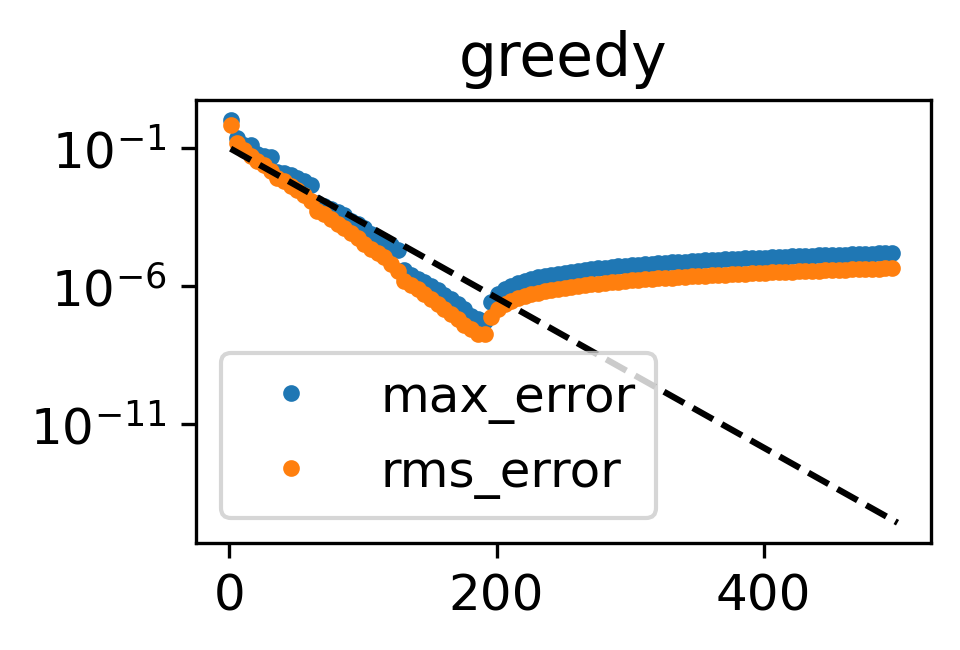

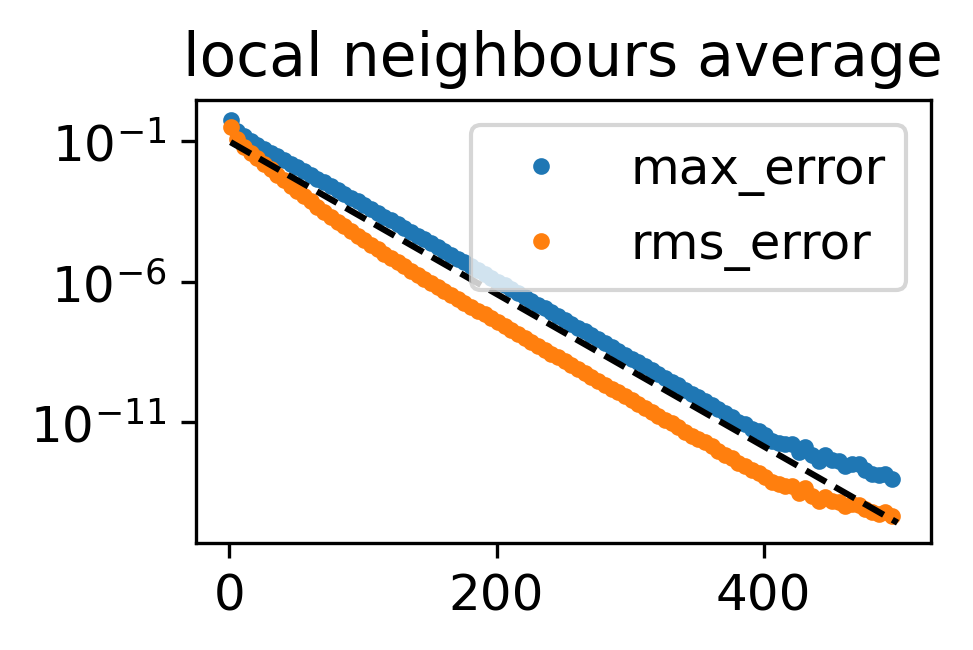

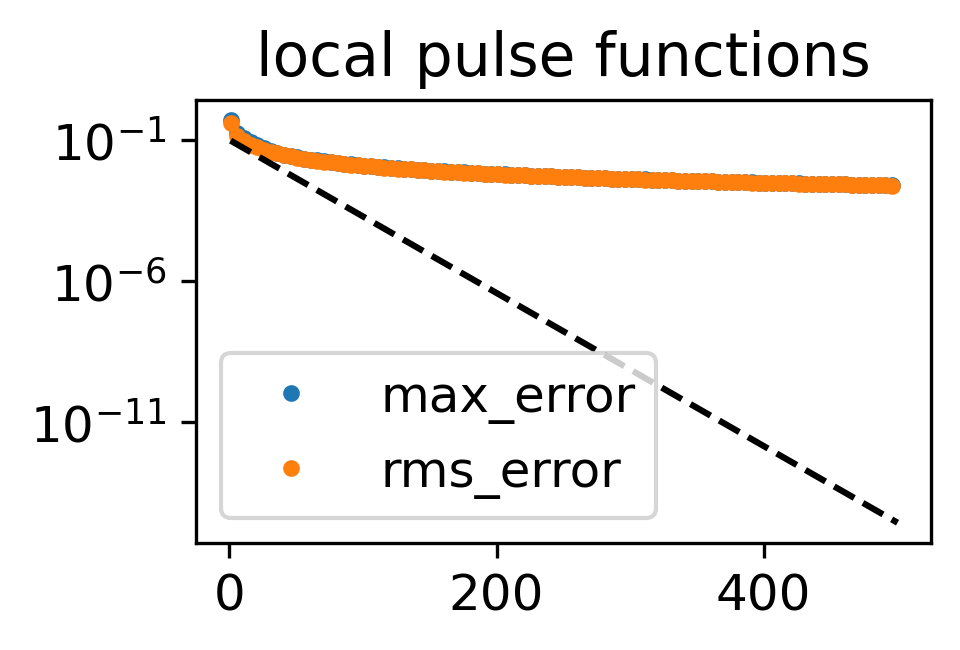

In [20]:
X_test = u_sg(x(), mu_test())
rms_error_sg, max_error_sg = [], []

for basis in [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]:
    rmse, maxe = basis.calc_error(X_test, r)
    rms_error_sg.append(rmse)
    max_error_sg.append(maxe)
    ax = plot_error(rmse, maxe)
    nn = np.arange(1, r+1)
    ax.plot(nn, .1/np.exp(nn/16), "k--", label=".1/e^(nn/16)")
    #ax.set_ylim(1/100, 1)
    #ax.set_xlim(0, 50)
    plt.title(basis.name)
    plt.show()

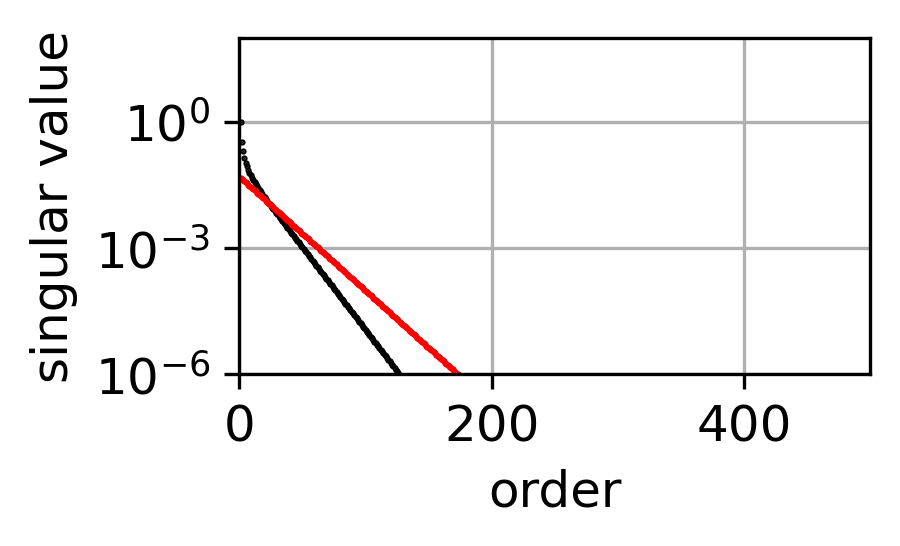

In [21]:
S = svd_basis.S
plot_singular_values(S)
plt.plot(nn, .05/np.exp(nn/16), "r.", ms=1)

## Summary
We have 4 initial conditions with different smoothness, nameley the heavidside function, the ramp function, a smooth jump and a sigmoid function.

We investigated four possible basis to approximate these cases

In [22]:
initc = [u_hs, u_rp, u_sj, u_sg]
basis = [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]
rmse = [rms_error_hs, rms_error_rp, rms_error_sj, rms_error_sg]  # 4, 5
maxe = [max_error_hs, max_error_rp, max_error_sj, max_error_sg]

### How do the different sets of basis vectors perform in each case?

{'ms': 1, 'label': 'heaviside'}
0.50025
{'ms': 1, 'label': 'ramp'}
0.50025
{'ms': 1, 'label': 'smooth jump'}
0.50025
{'ms': 1, 'label': 'sigmoid'}
0.50025


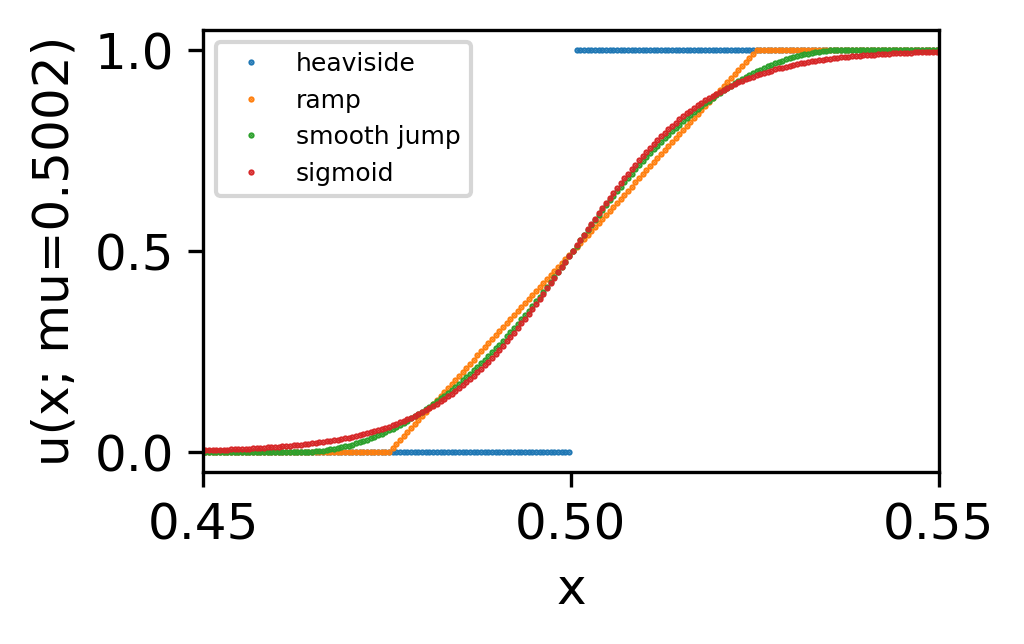

In [23]:
fig, ax = plt.subplots()
for i, ic in enumerate(initc):
    ic.plot(x(), ax=ax, ms=1, label=ic.name)
plt.xlim(.45, .55)
plt.legend(prop={'size': 6})
plt.show()

heaviside


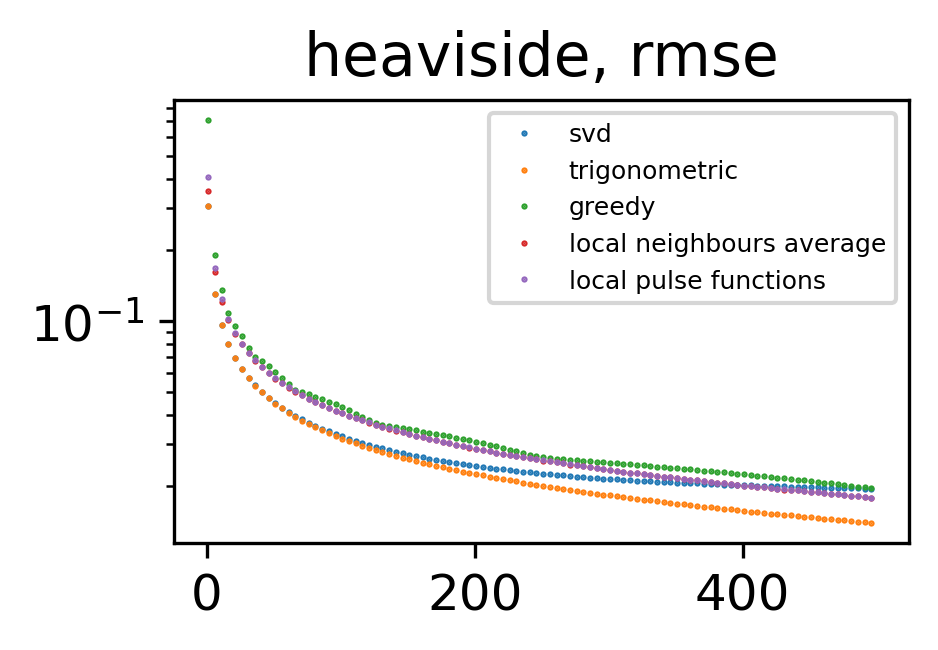

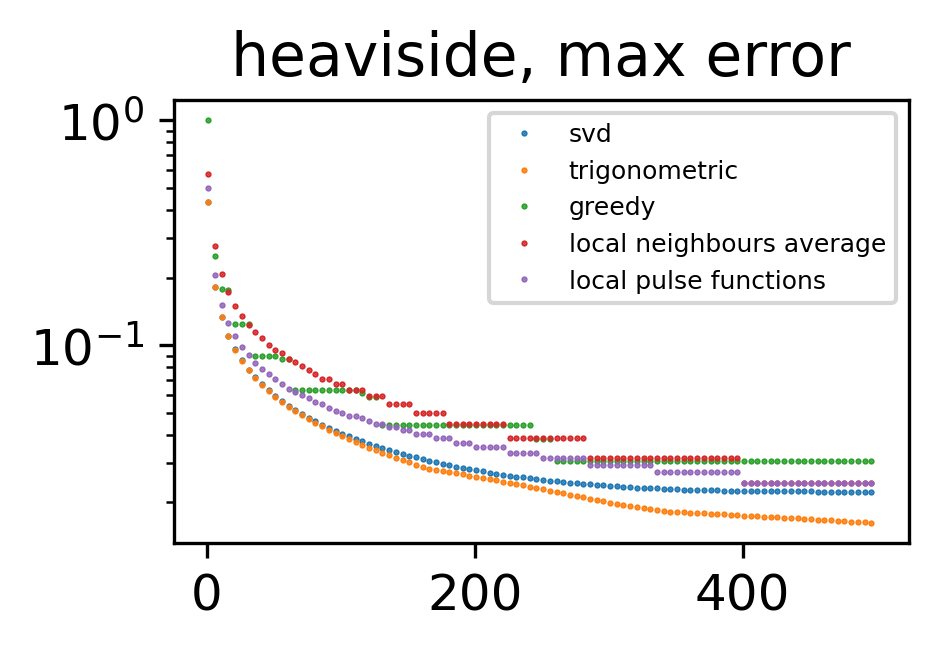

ramp


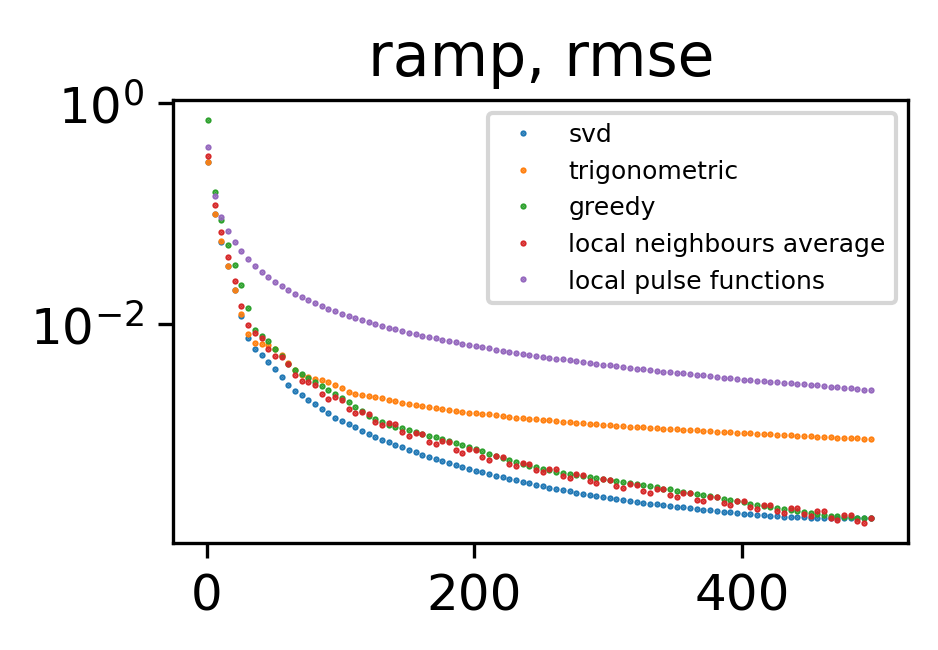

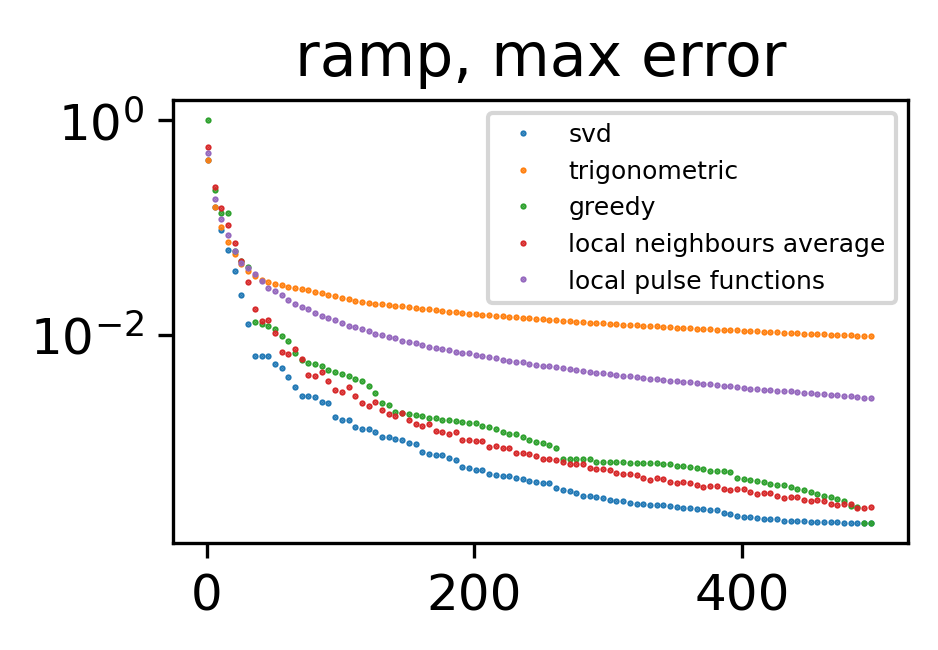

smooth jump


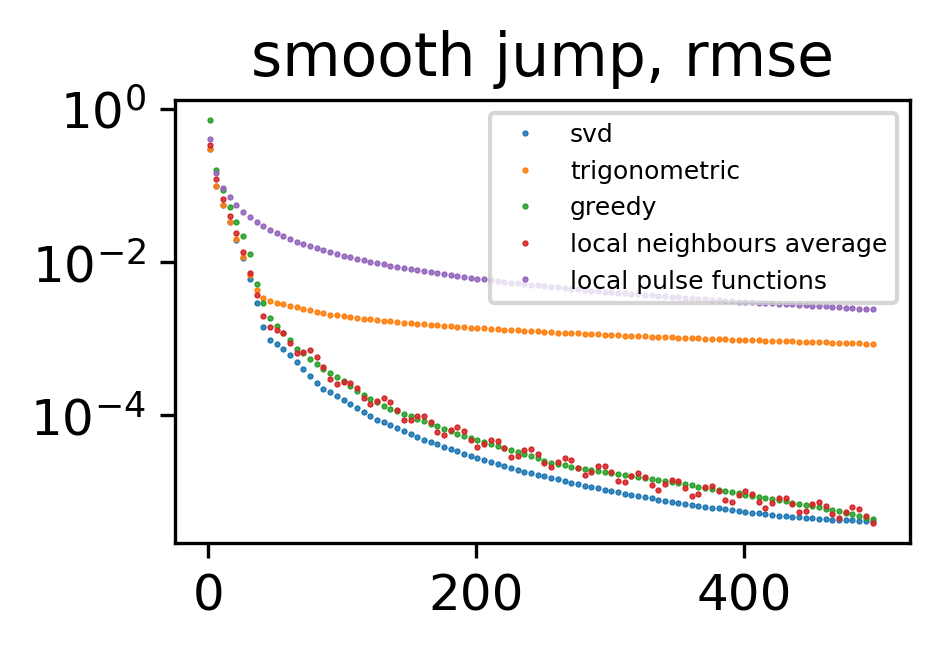

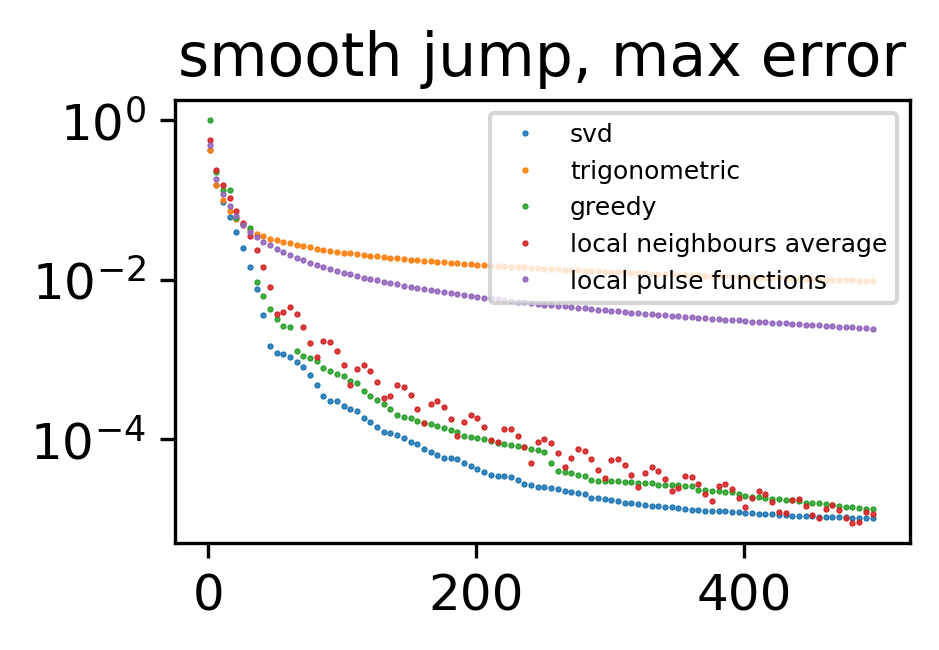

sigmoid


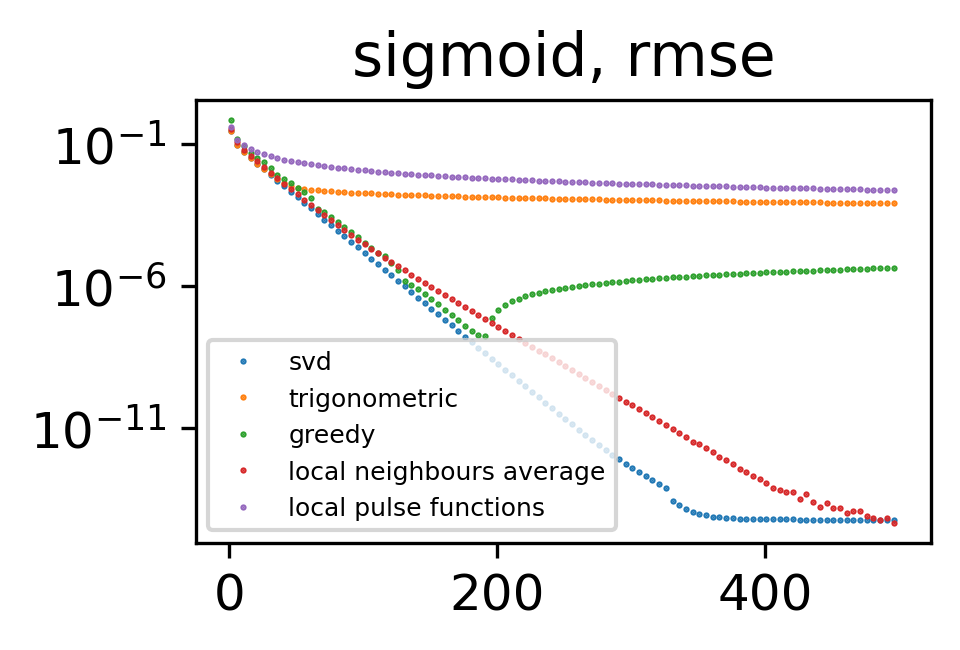

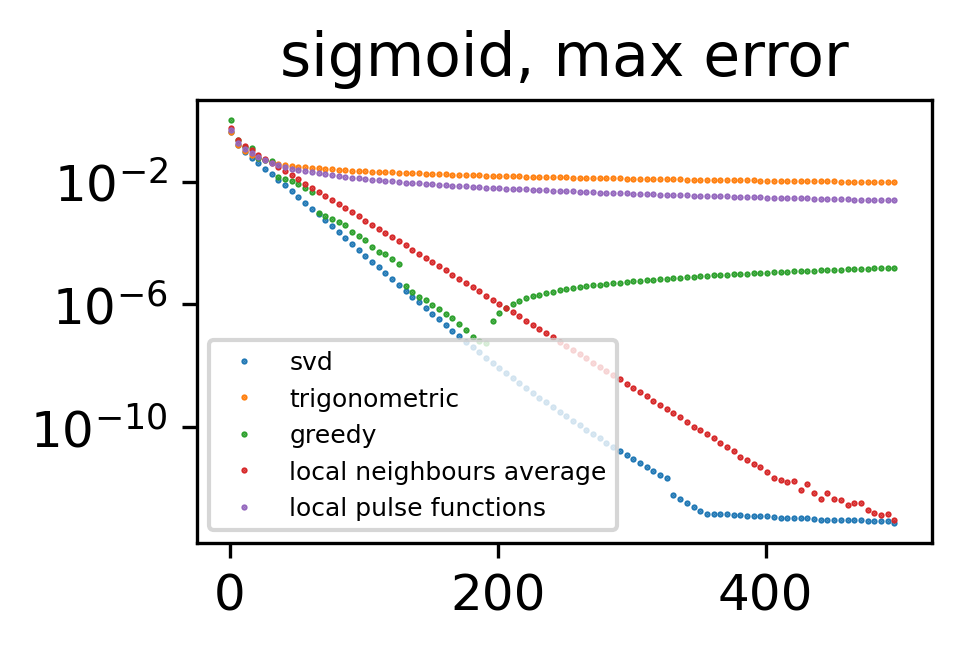

In [24]:
for i, ic in enumerate(initc):
    print(ic.name)
    fig, ax = plt.subplots()
    for j, bv in enumerate(basis):
        ax.plot(rmse[i][j], ".", ms=1, label=bv.name)
    ax.set_yscale('log')
    plt.title(ic.name+", rmse")
    plt.legend(prop={'size': 6})
    plt.show()
    
    fig, ax = plt.subplots()
    for j, bv in enumerate(basis):
        ax.plot(maxe[i][j], ".", ms=1, label=bv.name)
    ax.set_yscale('log')
    plt.title(ic.name+", max error")
    plt.legend(prop={'size': 6})
    plt.show()
    


### How do the different sets of basis vectors compare?

sigmoid


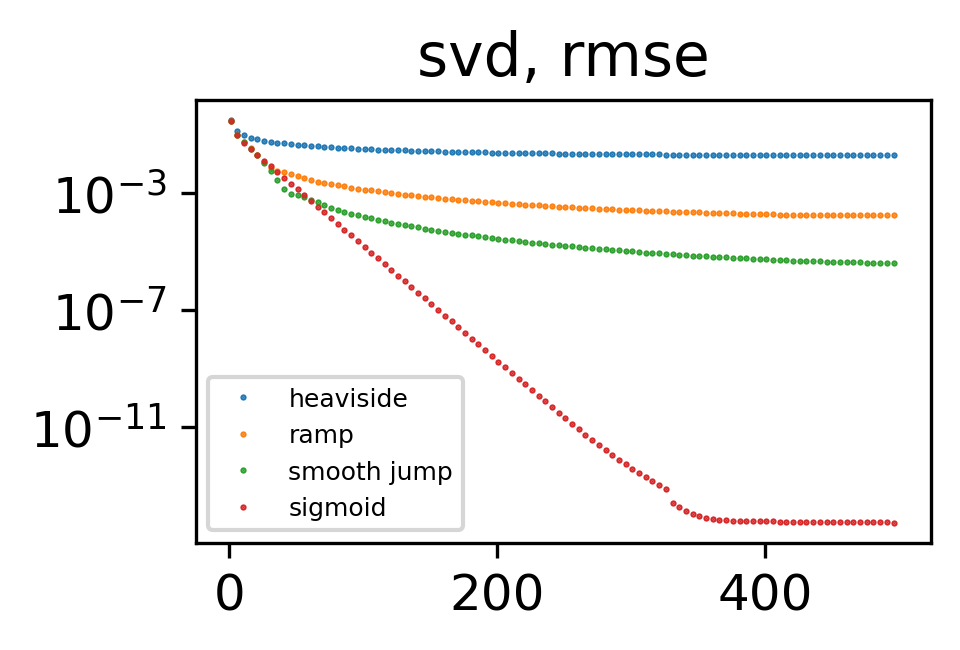

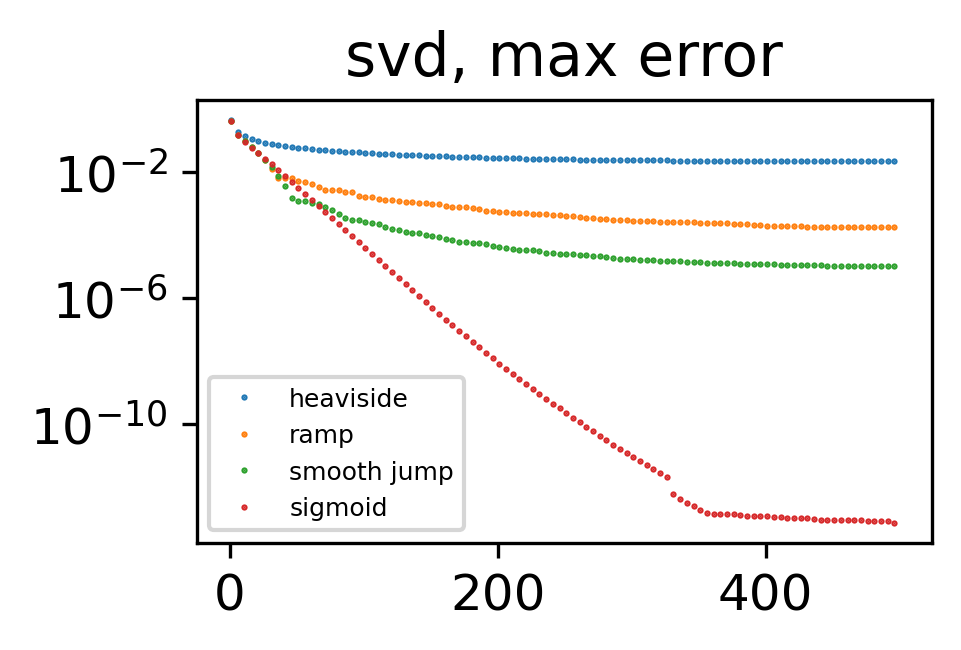

sigmoid


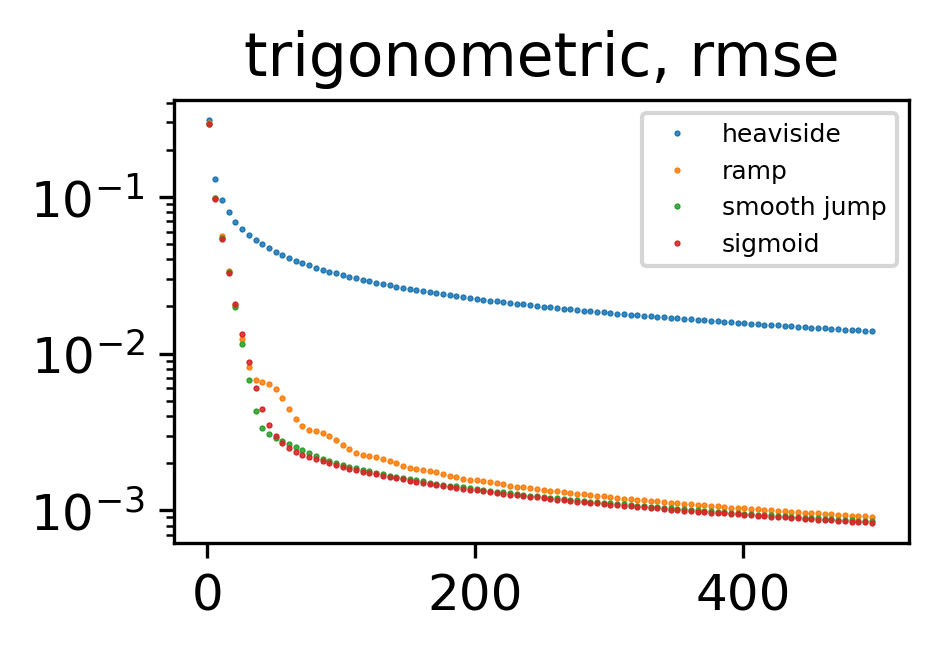

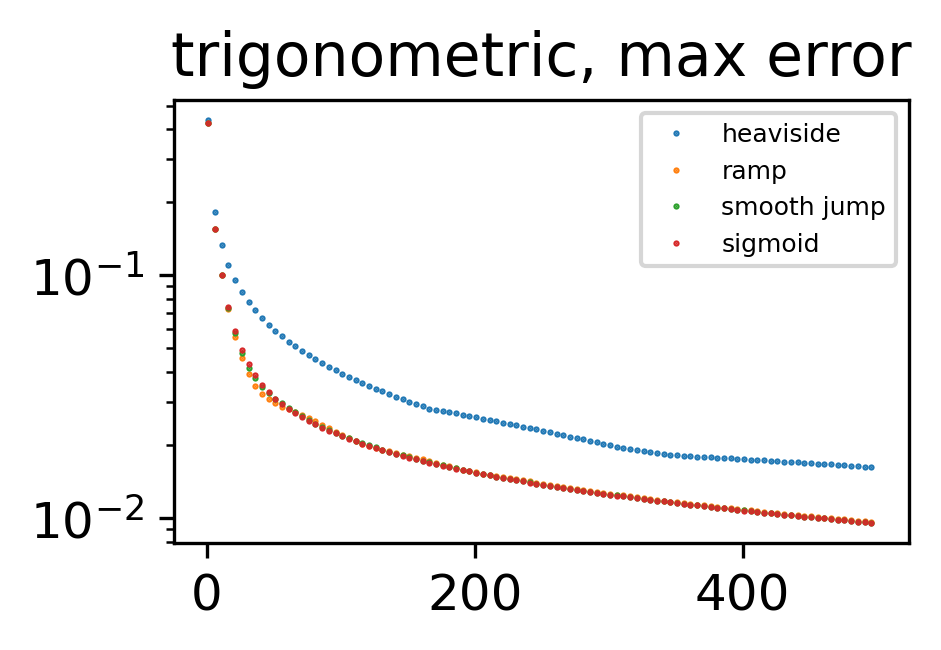

sigmoid


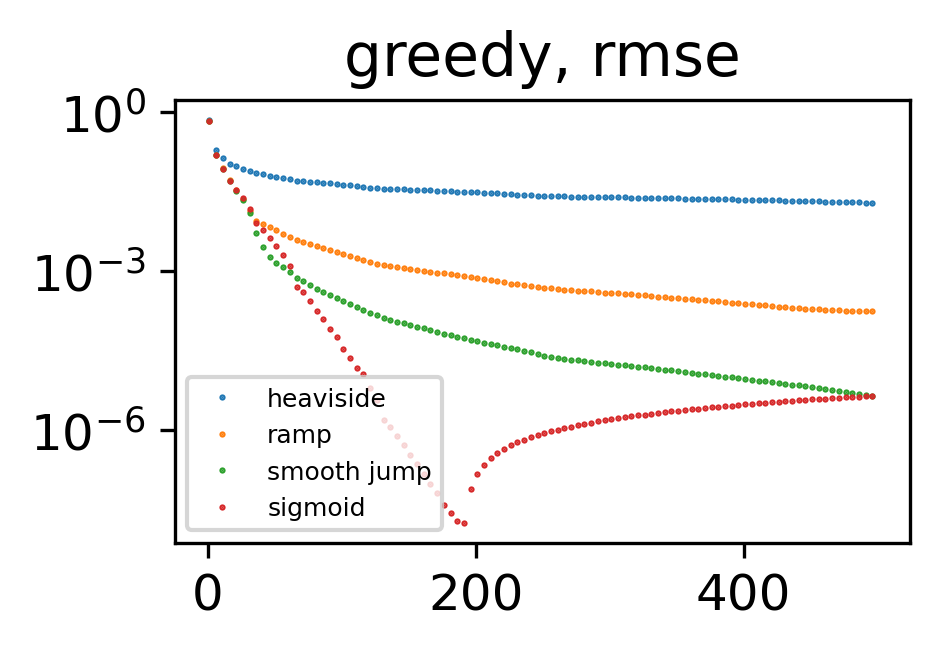

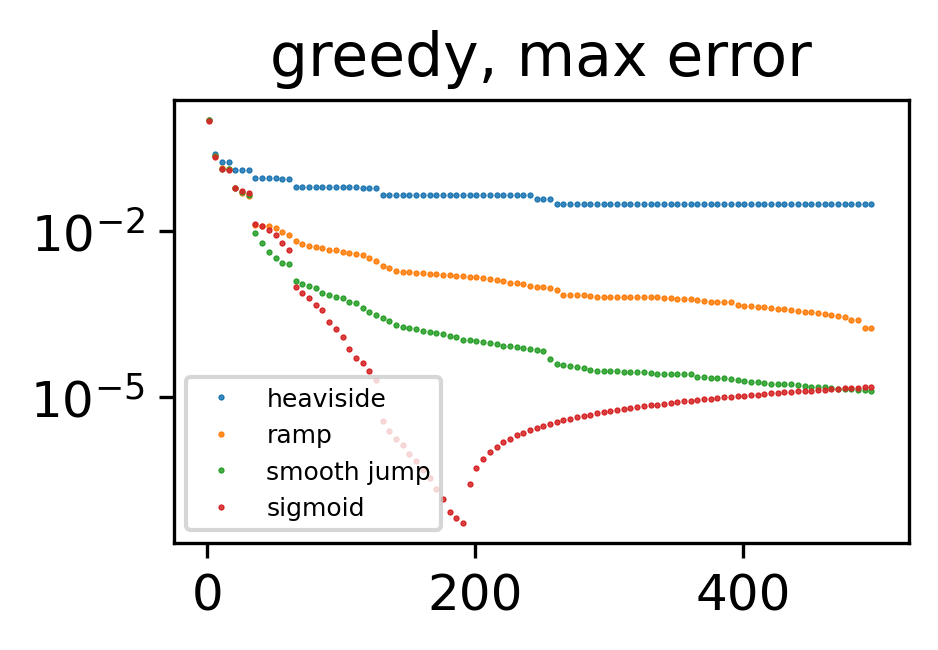

sigmoid


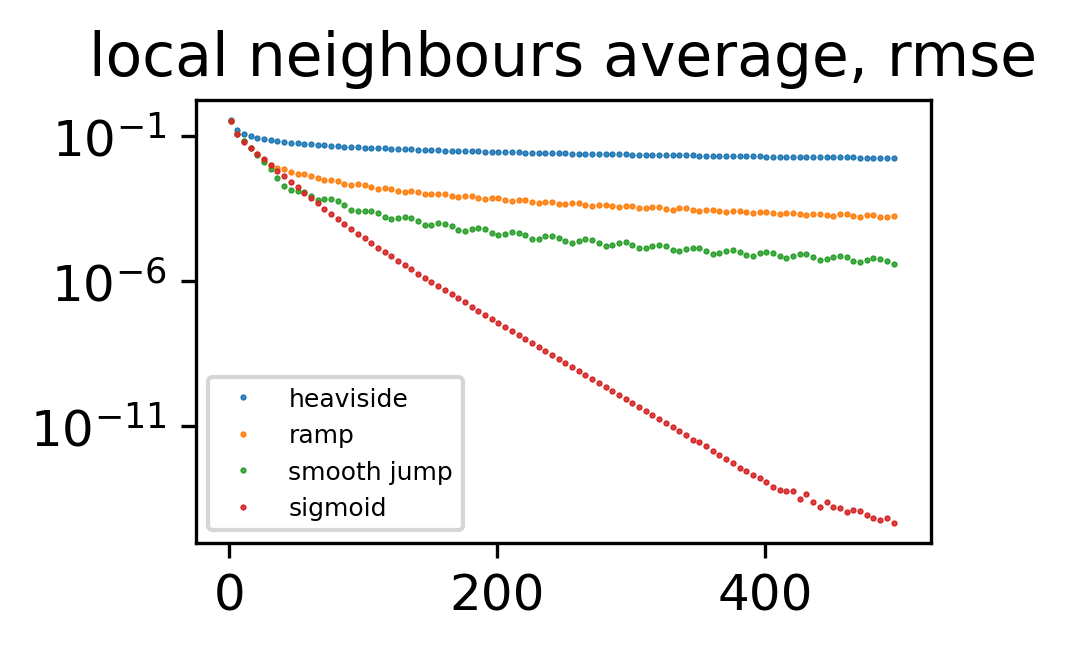

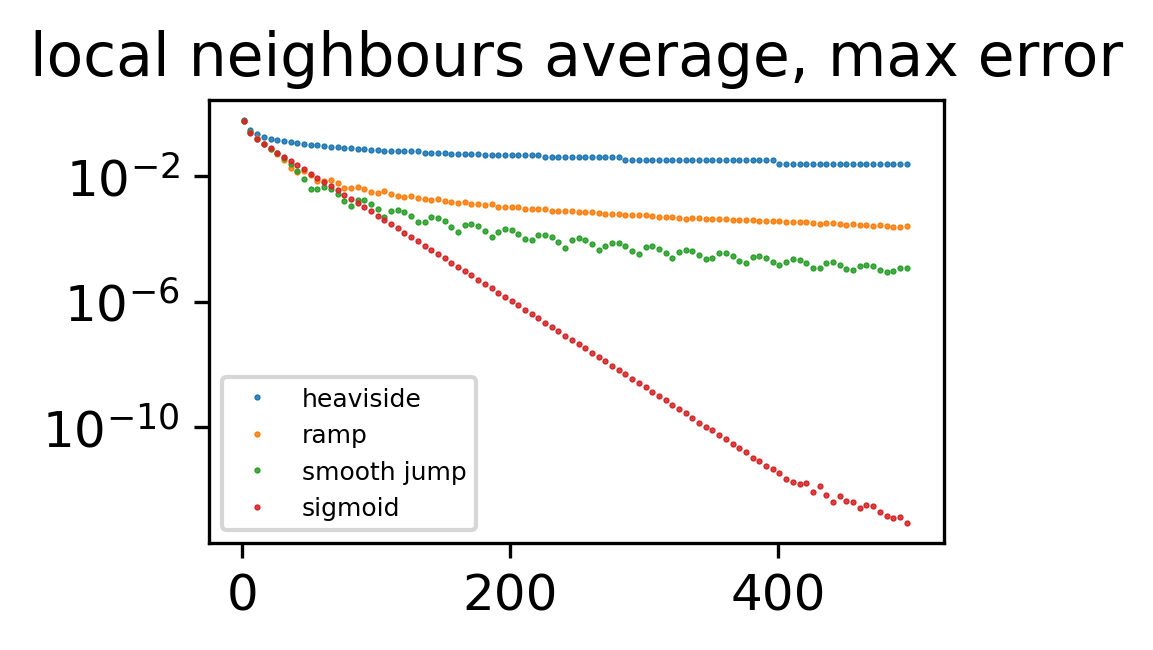

sigmoid


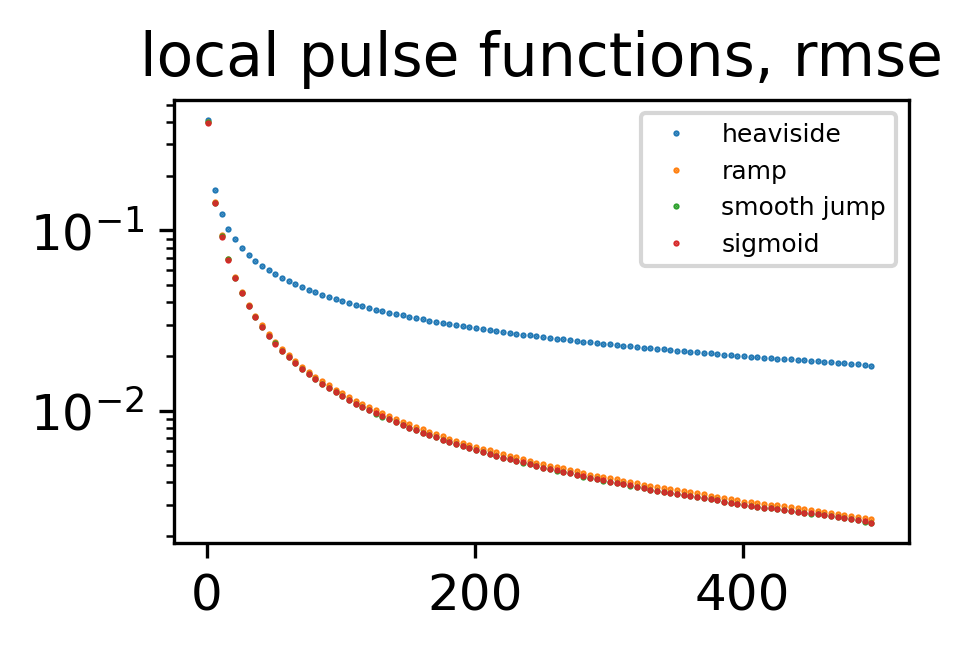

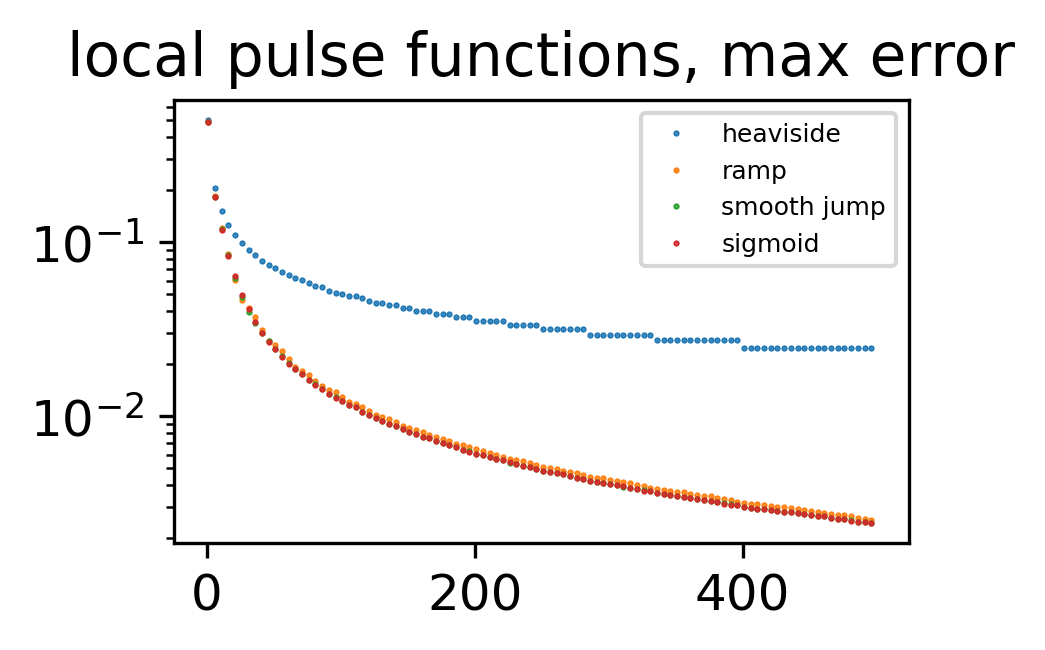

In [25]:
for j, bv in enumerate(basis):
    print(ic.name)
    fig, ax = plt.subplots()
    for i, ic in enumerate(initc):
        ax.plot(rmse[i][j], ".", ms=1, label=ic.name)
    ax.set_yscale('log')
    plt.title(bv.name+", rmse")
    plt.legend(prop={'size': 6})
    plt.show()
    
    fig, ax = plt.subplots()
    for i, ic in enumerate(initc):
        ax.plot(maxe[i][j], ".", ms=1, label=ic.name)
    ax.set_yscale('log')
    plt.title(bv.name+", max error")
    plt.legend(prop={'size': 6})
    plt.show()
    
